# Simulating regression results under noisy SEIR Model

This notebook evaluates the ability of our regression framework to obtain robust estimates for the impact of policy given the data available. Using a Monte Carlo approach, it simulates the outbreak progression using an SEIR model, allowing for noise in the $\beta$, $\gamma$, and $\sigma$ parameters, and allowing for $\beta$ to be affected by policy interventions. For each MC draw, it then uses our regression estimation framework to obtain estimates for the impact of those policies. We then compare the distribution of estimates with the true values, under various assumptions for the values of $\gamma$ and $\sigma$.

In [224]:
%load_ext autoreload
%autoreload 2

import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import xarray as xr
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from codes import utils as cutil
from codes.models import epi
from codes.plotting import sims as simplot

sns.set(context="paper", style="white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Settings

In [563]:
# sim settings
n_days = 35
tsteps_per_day = 24
pop = 2e4
I0 = 0
E0 = 1 / pop
R0 = 0
n_samples = 1000
gamma_to_test = [0.05, 0.2, 0.35]
sigma_to_test = [0.1, 0.3, 0.5]
reg_to_run = ["I", "EI", "IR", "EIR"]
policies_to_include = ["p1", "p2", "p3"]

# policy settings
no_policy_growth_rate = 0.4
p1_effect = -0.05
p1_day_st, p1_day_end = 10, 15
p2_effect = -0.1
p2_day_st, p2_day_end = 15, 20
p3_effect = -0.2
p3_day_st, p3_day_end = 20, 25

# stochasticity settings
beta_noise_on = True
beta_noise_sd = 0.08

gamma_noise_on = True
gamma_noise_sd = 0.08

sigma_noise_on = True
sigma_noise_sd = 0.08

# debug
# gamma_to_test = [.3]
# sigma_to_test = [0.3]
# n_samples = 100

## Run simulations

In [564]:
attrs = dict(
    n_days=n_days,
    tsteps_per_day=tsteps_per_day,
    pop=pop,
    I0=I0,
    E0=E0,
    R0=R0,
    n_samples=n_samples,
    no_policy_growth_rate=no_policy_growth_rate,
    p1_effect=p1_effect,
    p1_day_st=p1_day_st,
    p1_day_end=p1_day_end,
    p2_effect=p2_effect,
    p2_day_st=p2_day_st,
    p2_day_end=p2_day_end,
    p3_effect=p3_effect,
    p3_day_st=p3_day_st,
    p3_day_end=p3_day_end,
    beta_noise_on=beta_noise_on,
    gamma_noise_on=gamma_noise_on,
    sigma_noise_on=sigma_noise_on,
    beta_noise_sd=beta_noise_sd,
    gamma_noise_sd=gamma_noise_sd,
    sigma_noise_sd=sigma_noise_sd,
)

In [565]:
## Run simulation

# time
ttotal = n_days * tsteps_per_day + 1
t = np.linspace(0, 1, ttotal) * n_days

# initialize results array
estimates = epi.init_reg_arr(
    n_samples,
    len(reg_to_run),
    len(policies_to_include),
    len(gamma_to_test),
    len(sigma_to_test),
)

# get policy effects
policy_effects = np.array([p1_effect, p2_effect, p3_effect])
policy_dummies = epi.init_policy_dummies(
    policy_effects,
    [p1_day_st, p2_day_st, p3_day_st],
    [p1_day_end, p2_day_end, p3_day_end],
    n_samples,
    ttotal,
    tsteps_per_day,
    seed=0,
)
n_samp_valid = policy_dummies.shape[0]
policy_effect_arr = (policy_dummies * policy_effects).sum(axis=2)

# get deterministic params
growth_rate_deterministic = np.ones(ttotal) * no_policy_growth_rate + policy_effect_arr
beta_deterministic = epi.get_beta_SEIR(
    growth_rate_deterministic, gamma_to_test, sigma_to_test
)

# get stochastic params
beta_stoch, gamma_stoch, sigma_stoch = epi.get_stochastic_params(
    beta_deterministic,
    beta_noise_sd,
    beta_noise_on,
    gamma_to_test,
    gamma_noise_sd,
    gamma_noise_on,
    sigma_to_test=sigma_to_test,
    sigma_noise_sd=sigma_noise_sd,
    sigma_noise_on=sigma_noise_on,
)

beta_stoch, gamma_stoch, sigma_stoch = epi.adjust_timescales_from_daily(
    tsteps_per_day, beta_stoch, gamma_stoch, sigma_stoch
)

# run sim
for gx, gamma in enumerate(gamma_to_test):
    for sx, sigma in enumerate(sigma_to_test):
        print("Running sim for gamma =", gamma, ", sigma =", sigma)
        for samp in range(n_samp_valid):

            # get sample params
            this_beta = beta_stoch[samp, :, gx, sx]
            this_gamma = gamma_stoch[samp, :, gx]
            this_sigma = sigma_stoch[samp, :, sx]
            this_policies = policy_dummies[samp]

            # run dynamic model
            SEIR_res = epi.run_SEIR(
                ttotal, E0, I0, R0, this_beta, this_gamma, this_sigma
            )

            # get case dataframe
            cases = epi.get_case_df(
                "SEIR",
                SEIR_res,
                this_policies,
                t,
                tsteps_per_day,
                pop,
                param_arr_dict={
                    "gamma": this_gamma,
                    "beta": this_beta,
                    "sigma": this_sigma,
                },
                debug=True,
            )

            # run regressions
            estimates[samp, gx, sx] = epi.run_regressions(
                cases, reg_to_run, policies_to_include, 10
            )

params = OrderedDict(gamma=gamma_to_test, sigma=sigma_to_test)
estimates_ds = epi.res_arr_to_ds(
    estimates, reg_to_run, policies_to_include, params, **attrs
)

Running sim for gamma = 0.05 , sigma = 0.1
Running sim for gamma = 0.05 , sigma = 0.3
Running sim for gamma = 0.05 , sigma = 0.5
Running sim for gamma = 0.2 , sigma = 0.1
Running sim for gamma = 0.2 , sigma = 0.3
Running sim for gamma = 0.2 , sigma = 0.5
Running sim for gamma = 0.35 , sigma = 0.1
Running sim for gamma = 0.35 , sigma = 0.3
Running sim for gamma = 0.35 , sigma = 0.5


In [566]:
save_fpath = cutil.HOME / "results" / "other" / f"seir_sim_estimates_pop_{int(pop)}.nc"
save_fpath.parent.mkdir(exist_ok=True, parents=True)
estimates_ds.to_netcdf(save_fpath)

## Plot results

### Histograms of estimates

These plots show potential bias in our estiamted parameters: The "no-policy" growth rate and the effects on that growth rate of each policy.

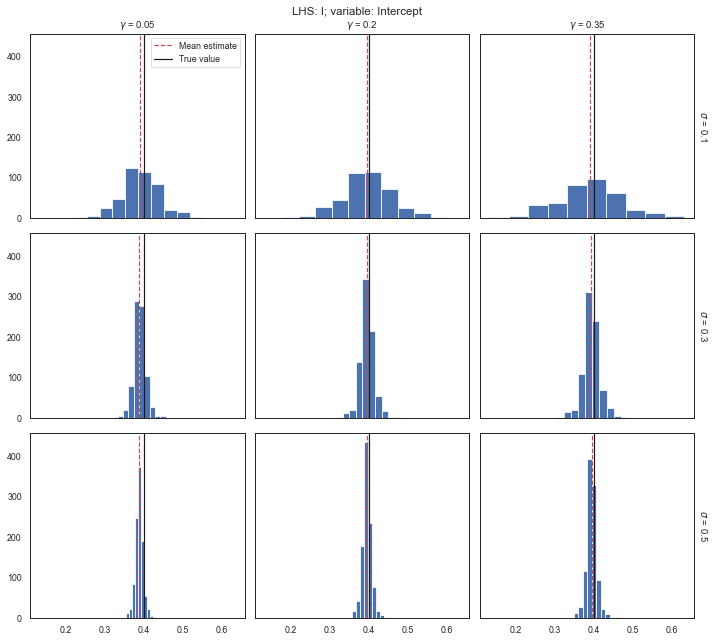

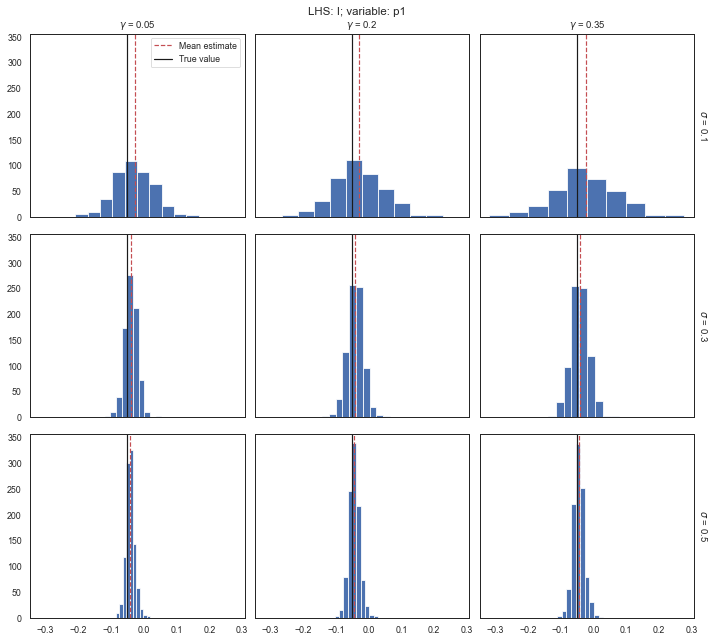

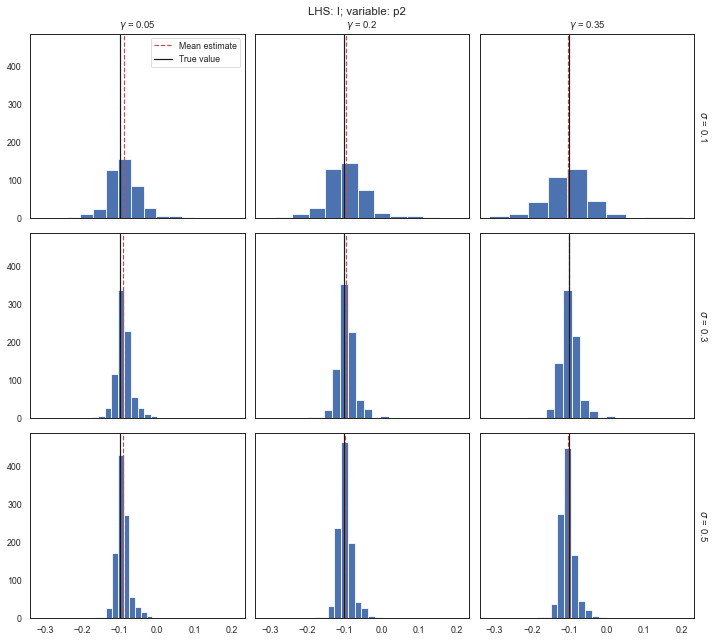

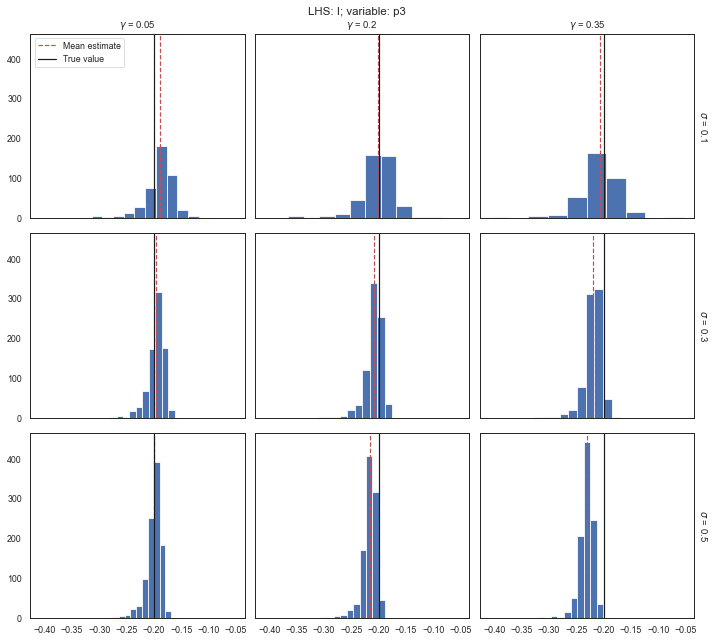

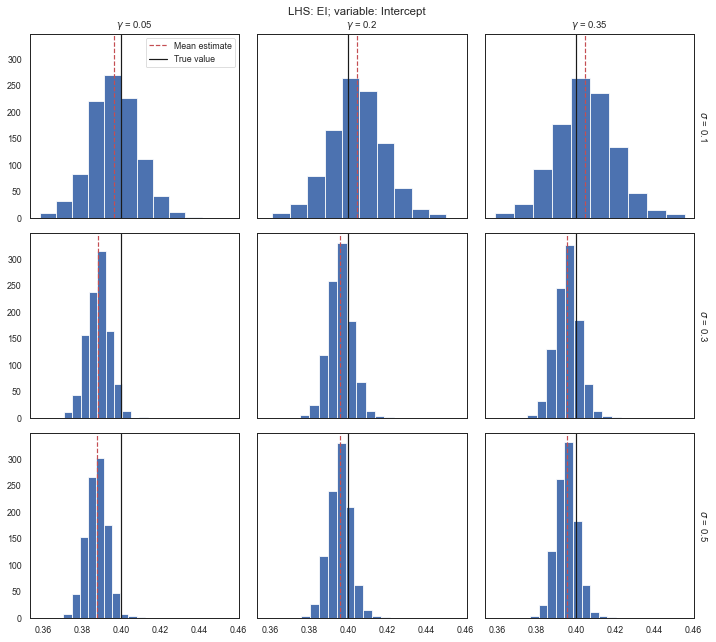

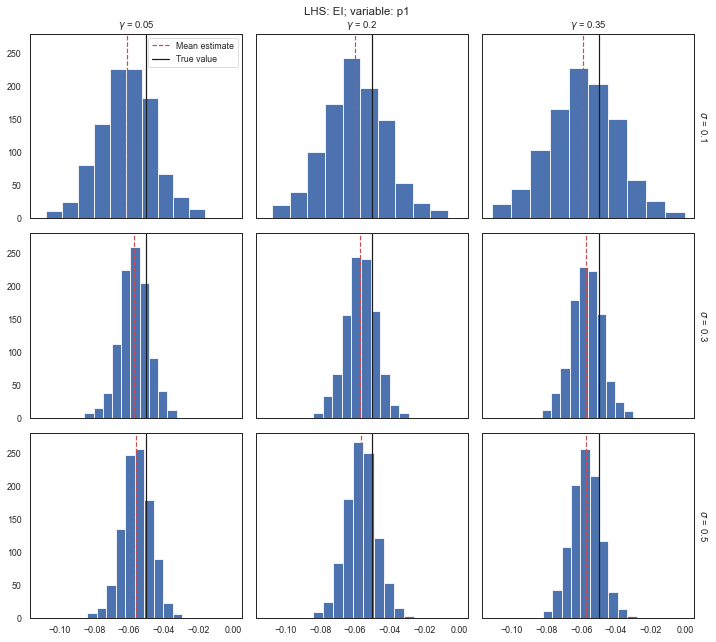

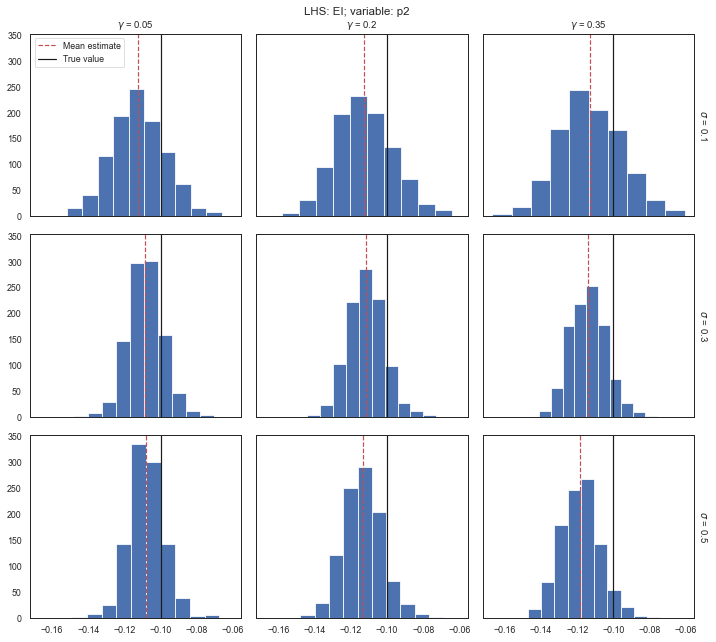

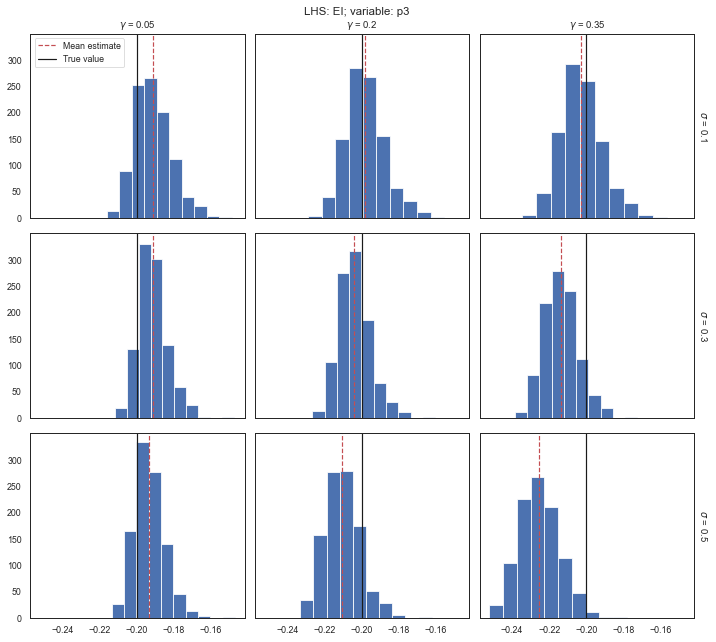

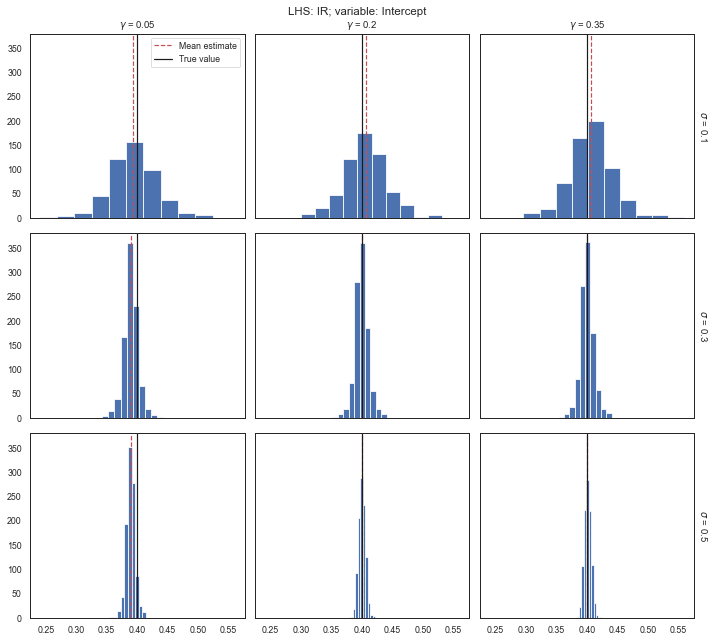

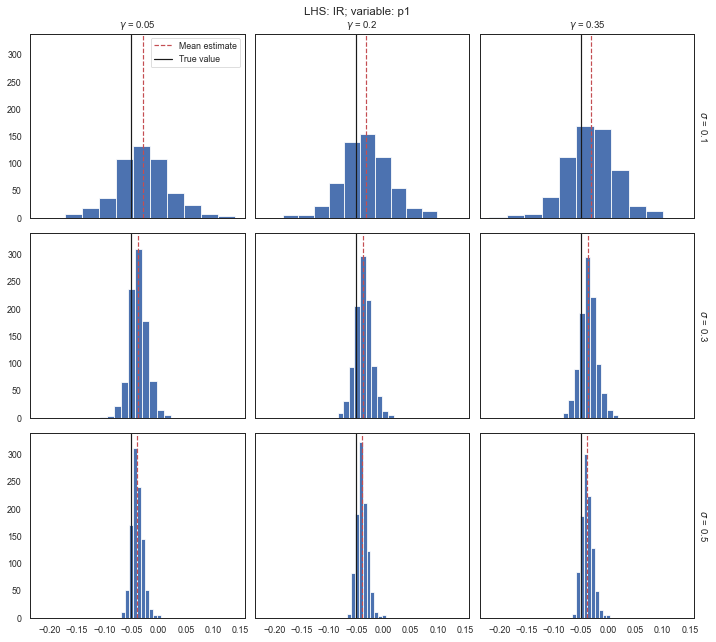

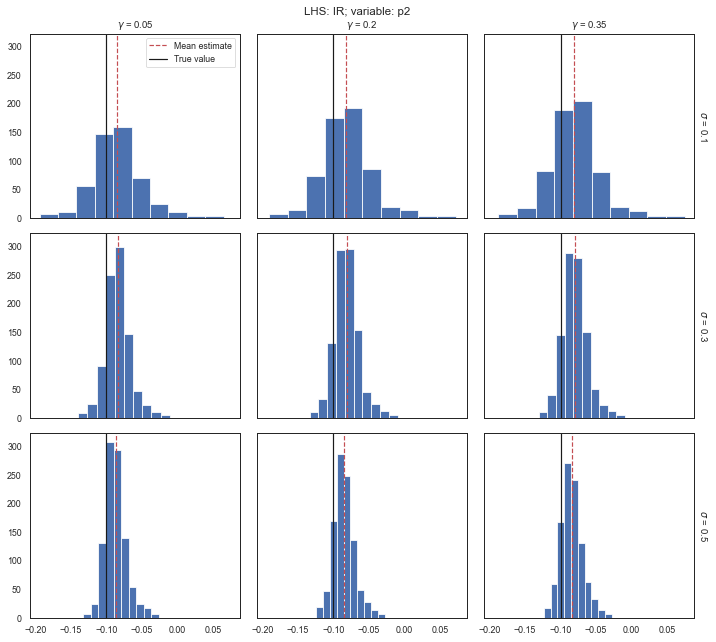

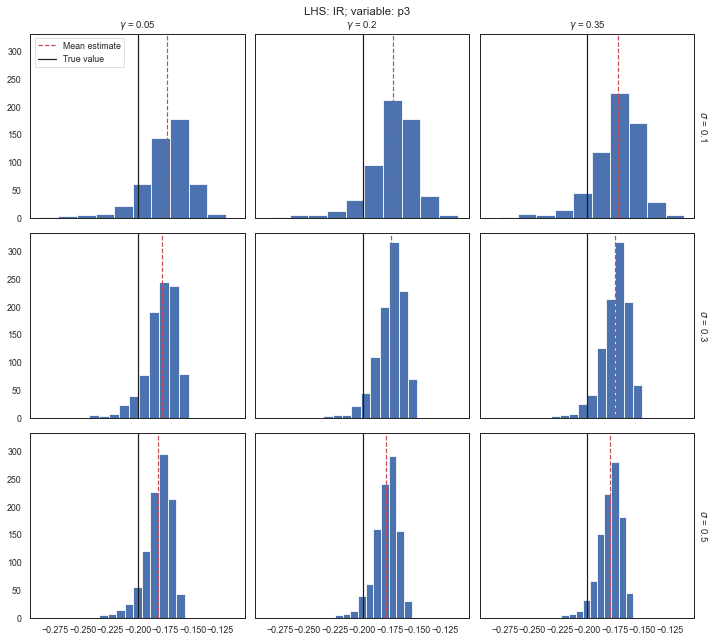

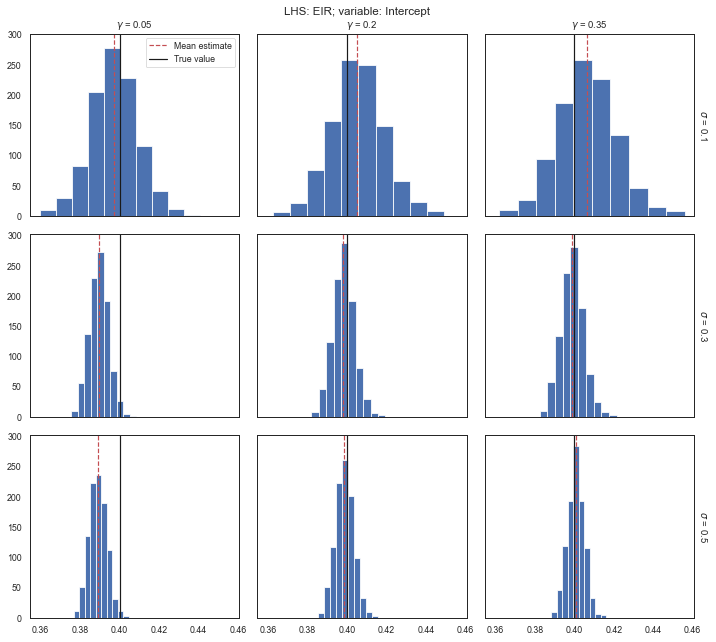

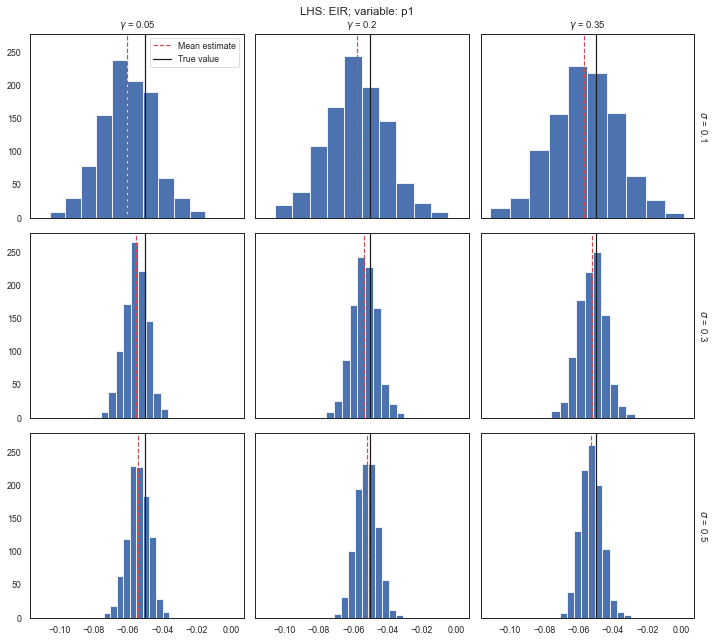

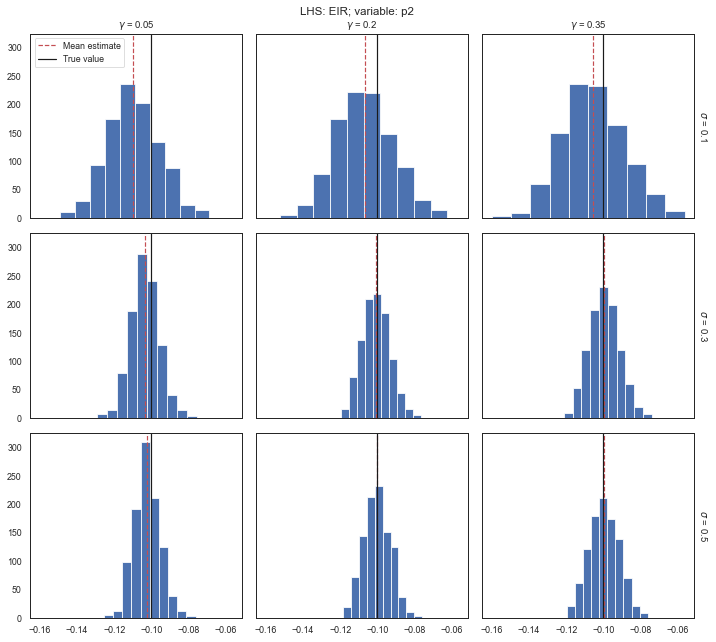

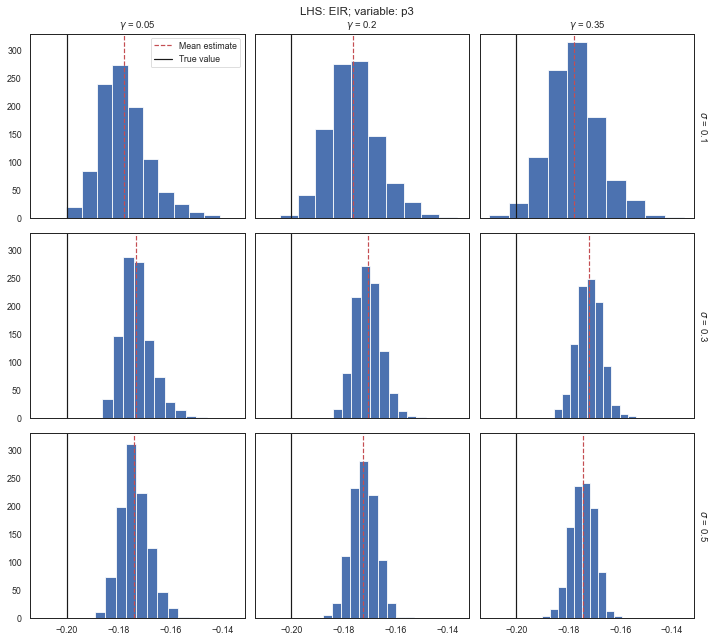

In [569]:
out_dir = cutil.HOME / "results" / "figures" / "sims"
out_dir.mkdir(parents=True, exist_ok=True)

for c in estimates_ds.case_type.values:
    for v in estimates_ds.data_vars:
        bn, gn, sn = (0, 0, 0)
        if beta_noise_on:
            bn = beta_noise_sd
        if gamma_noise_on:
            gn = gamma_noise_sd
        if sigma_noise_on:
            sn = sigma_noise_sd
        out_path = (
            out_dir
            / f"SEIR_sim_reg_results_{c}_{v}_betaNoise_{bn}_gammaNoise_{gn}_sigmaNoise_{sn}_pop{int(pop)}.pdf"
        )
        g = simplot.facet_hist(estimates_ds, c, v, col="gamma", row="sigma")
        g.fig.savefig(out_path, dpi=300, tight_layout=True, bbox_inches="tight")

### Convergence of cumulative cases growth to active cases growth

These plots show how the growth rates in cumulative cases converge to the growth rates in active cases under a S ~= 1 regime (assuming no policy and no noise in $\gamma$).

In [514]:
this_pop = 5e3

In [515]:
this_E0 = 0 / this_pop
this_I0 = 1 / this_pop
this_R0 = 0 / this_pop

out = np.empty(
    (len(reg_to_run), len(gamma_to_test), len(sigma_to_test), ttotal), dtype=np.float32
)
out.fill(np.nan)
coords = OrderedDict(
    case_type=reg_to_run, gamma=gamma_to_test, sigma=sigma_to_test, t=t
)
res_da = xr.DataArray(coords=coords, dims=coords.keys(), data=out).to_dataset(
    dim="case_type"
)
for i in reg_to_run:
    res_da[i + "_logdiff"] = res_da[i].copy()
res_da["S"] = res_da["I"].copy()

# run sim
for gx, gamma in enumerate(gamma_to_test):
    for sx, sigma in enumerate(sigma_to_test):

        # get sample params
        this_beta = beta_deterministic[0, 0, gx, sx] * np.ones(ttotal) / tsteps_per_day
        this_gamma = gamma * np.ones(ttotal) / tsteps_per_day
        this_sigma = sigma * np.ones(ttotal) / tsteps_per_day

        # one policy to adjust to in the middle
        policy_on = int(ttotal / 2)
        beta_pol = beta_deterministic[0, -1, gx, sx] / tsteps_per_day
        this_beta[policy_on:] = beta_pol

        # run dynamic model
        S, E, I, R = epi.run_SEIR(
            ttotal, this_E0, this_I0, this_R0, this_beta, this_gamma, this_sigma
        )
        res_da["S"][gx, sx] = S
        res_da["I"][gx, sx] = I
        res_da["EI"][gx, sx] = I + E
        res_da["IR"][gx, sx] = I + R
        res_da["EIR"][gx, sx] = E + I + R

        for i in reg_to_run:
            a = res_da[i][gx, sx] * this_pop
            a = np.log(a).diff("t", 1)
            a["t"] = t[:-1]
            res_da[i + "_logdiff"][gx, sx, :-1] = a * tsteps_per_day
            res_da[i + "_logdiff"][gx, sx, -1] = np.nan

/Users/ianbolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


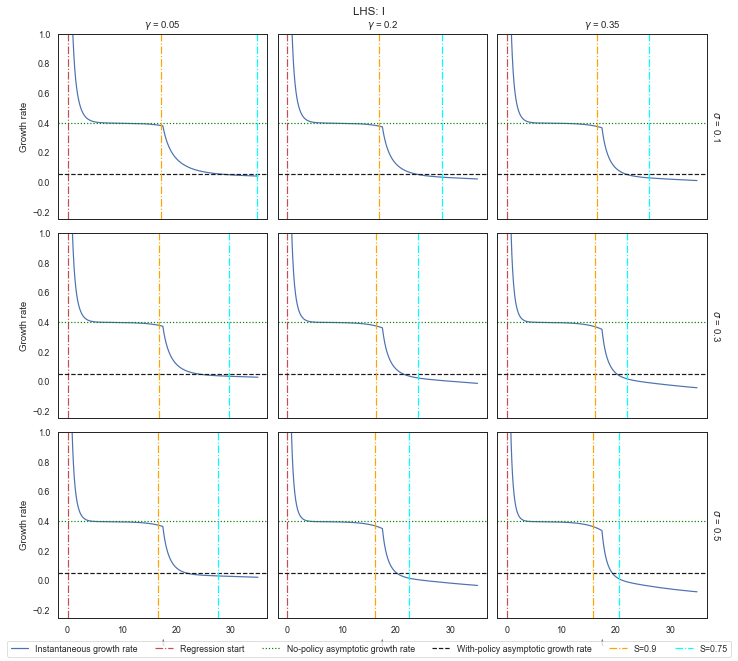

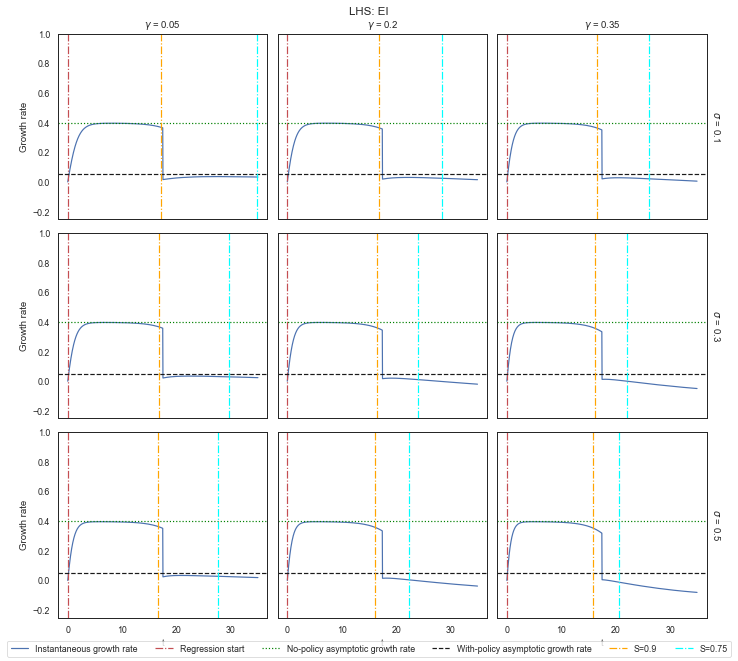

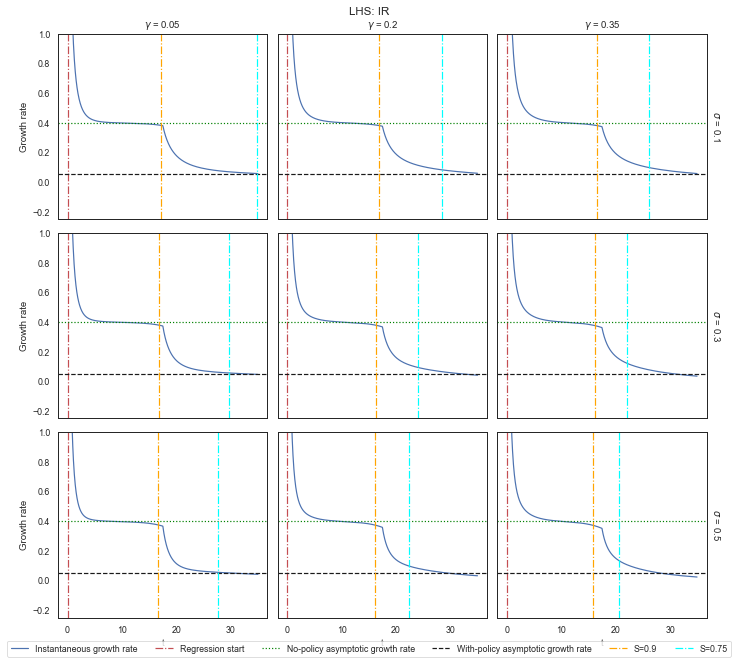

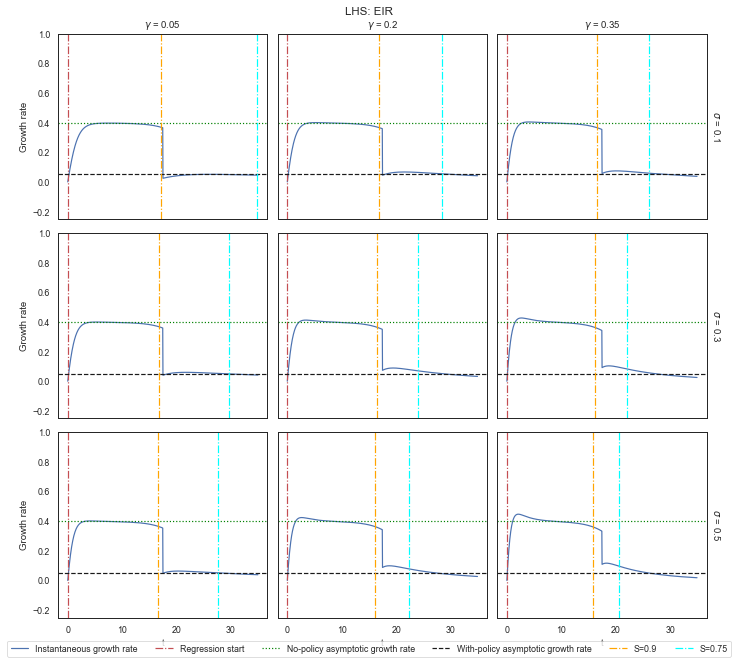

In [531]:
S_da = res_da.S
for case_type in reg_to_run:
    varname = case_type + "_logdiff"
    g = res_da[varname].plot(
        x="t", col="gamma", row="sigma", ylim=(-.25, 1), label="Instantaneous growth rate"
    )
    for ax, namedict in zip(g.axes.flat, g.name_dicts.flat):
        casedata = res_da[case_type].loc[namedict]
        sdata = res_da.S.loc[namedict]
        ax.axvline(
            casedata.t[casedata >= (10 / pop)][0].item(),
            color="r",
            linestyle="-.",
            label="Regression start",
        )
        ax.axhline(
            no_policy_growth_rate,
            color="green",
            linestyle=":",
            label="No-policy asymptotic growth rate",
        )
        ax.axhline(
            no_policy_growth_rate + policy_effects.sum(),
            color="k",
            linestyle="--",
            label="With-policy asymptotic growth rate",
        )
        ax.axvline(
            sdata.t[sdata <= .9][0].item(),
            color="orange",
            linestyle="-.",
            label="S=0.9",
        )
        ax.axvline(
            sdata.t[sdata <= .75][0].item(),
            color="cyan",
            linestyle="-.",
            label="S=0.75",
        )
    g.fig.legend(*g.axes.flat[0].get_legend_handles_labels(), loc="lower center", ncol=6)
    g.set_titles("$\{coord}$ = {value}")
    g.set_ylabels("Growth rate")
    g.fig.suptitle(f"LHS: {case_type}", va="bottom", y=0.99)
    g.fig.savefig(out_dir / f"growth_sim_{case_type}_pop_{this_pop}.pdf", dpi=300, tight_layout=True)